# Install Packages
We first install the packages required for this notebook. Unfortunately because of the way pip and jupyter works after running the following commands a restart of the kernel/runtime is necessary.

In [ ]:
!pip install -e ../Environments
!pip install matplotlib

# <span style="color:red">Restart the kernel</span>

# Required Imports

In [26]:
# for using the env that we built
import gym
# for number crunching and storing results
import numpy as np

# plotting the graphs
from matplotlib import pyplot as plt

# Seed for this environment

In [27]:
np.random.seed(1)

# Policy and the helping function to sample action 

In [28]:
# policy, given state pmf for actions
right_policy = { 1 : [ 1.0, 0.0 ],
           2 : [ 1.0, 0.0 ],
           3 : [ 1.0, 0.0 ],
           4 : [ 1.0, 0.0  ],
           5 : [ 1.0, 0.0  ]
           }

left_policy = { 1 : [ 0.0, 1.0 ],
           2 : [ 0.0, 1.0 ],
           3 : [ 0.0, 1.0 ],
           4 : [ 0.0, 1.0  ],
           5 : [ 0.0, 1.0  ]
           }



# helping function to take action given a policy and state
def take_action(pi, observation ):
    return np.random.choice([0,1], 1, p = pi[observation], replace=True)

# generateTrajectory function(2.1)

In [29]:
# function to generate samples of trajectory given dynamics function and policy
def generateTrajectory(env, pi, maxSteps):
    trajectory = []

    # starting the trajectory
    last_state = env.reset()
    is_terminal = False
    for i in range (maxSteps):
        action = take_action(pi, last_state)
        next_state , reward, is_terminal, _ = env.step(action)

        trajectory.append((last_state, int(action), reward, next_state))

        # if the agent completes before, just break
        if is_terminal:
            break#return


        last_state = next_state
    # won't consider the trajectories that went beyond maxsteps, assuming the agent has been trapped
    # and this trajectory is not important now.
    if is_terminal == True:
        return tuple(trajectory)

# decayAlpha function(2.2)

In [30]:
# decay type, can exponential and linear
decay_type_dict = {"Exp":0, "Lin":1}

# function to generate decaying alpha values for the number of episodes
def decayAlpha(initialValue, finalValue, maxSteps, decayType = decay_type_dict["Exp"]):

    # exponential lamda parameter, try playing with this parameter
    lamda = 0.03

    # for generating the next decayed alpha
    def generateAlpha( t, param = lamda ):
        if decayType == decay_type_dict["Exp"]:
            return (initialValue-finalValue)*np.exp(-t*param) + finalValue

        elif decayType == decay_type_dict["Lin"]:
            return ((finalValue - initialValue)*t + maxSteps*initialValue)/maxSteps

    alpha_values = []

    for i in range(maxSteps):
        alpha_values.append( generateAlpha(i) )

    return alpha_values

# Plotting trend for decayAlpha(2.2)

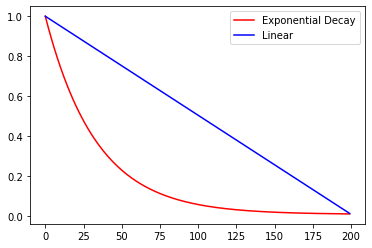

In [31]:
alpha_values_exp = decayAlpha(1, 0.01, 200, decayType=decay_type_dict["Exp"] )

    #plt.plot(alpha_values)

alpha_values_lin = decayAlpha(1, 0.01, 200, decayType=decay_type_dict["Lin"] )

plt.figure(0)
plt.plot(alpha_values_exp, color= 'r', label= "Exponential Decay")
plt.plot(alpha_values_lin, color = 'b', label = "Linear")
plt.legend()



# MonteCarlePrediction function for FirstVisit as well as EveryVisit(2.3)

In [32]:
# main montecarlo prediction function
def MonteCarloPrediction(env, pi, maxSteps, num_episodes = 500, first_visit = True, gamma= 0.99):

    # for storing the target values of state three ie the return value
    target_values_for_state_three = []

    # required bookkeeping arrays for checking out the trends followed ,and their population
    v = []
    visited = []
    v_r = []
    num_states = 7

    for i in range(0,num_states):
        v.append(0)
        visited.append(False)


    visited = np.array(visited)
    # need alphas for all episodes using the certain criteria given in the question, consider changing exponential to linear
    # for fun
    alpha_values = decayAlpha( 0.5, 0.01, int(num_episodes/2), decay_type_dict["Exp"] )
    alpha_values = np.array(alpha_values + int((num_episodes/2))*[0.01])

    # if you would like to see what trend is followed by alpha while decaying
    plt.figure(0)
    plt.title("Alpha_value decaying trend used")
    plt.xlabel("num_episodes")
    plt.ylabel("alpha value")
    plt.plot(alpha_values)

    # for each episode, we get a sample trajectory, using that trajectory
    # compute a sample for return and than we can use this sample to compute
    # expected return .i.e. the value function of a state
    for n in range(num_episodes):
        alpha = alpha_values[n]

        t = generateTrajectory(env, pi, maxSteps)
        if t == None:
            continue

        # before starting the trajectory, just reinitialise the visited array
        for i in range(num_states):
            visited[i] = False

        # for each point in the trajectory, compute the return for the state
        for i, (s, a, r, s1) in enumerate(t):

            # flag checking for visited and first visit
            if visited[s] and first_visit:
                continue
            visited[s] = True
            ret = 0
            for j in range(i, len(t)):
                r = t[j][2]
                ret += (gamma**(j-i)) * r

            # just for the third state, compute the target value
            if s == 3:
                target_values_for_state_three.append(ret)

            # compute the error and use to compute the average
            error = ret - v[s]
            v[s] = v[s] + alpha*error

        # append to store the running values so that later we can see the trend
        v_r.append(np.array(v).copy())

    return np.array(v), np.array(v_r), np.array(target_values_for_state_three)

# Testing MonteCarloPrediction(2.3)
the perfect way to test this here is first we compute optimal values of states, and than compare these values with values predicted by Prediction algo. 

# True State values for Right Policy
Kindly consider referring to lecture-4 slides to see how we computed below matrix.

In [33]:
 gamma = 0.99
# solving the policy
A = np.array([[1, 0, 0, 0, 0, 0, 0],
    [0, -1, 0.5*gamma, 0, 0, 0, 0],
    [0, 0.5*gamma, -1, 0.5*gamma, 0, 0 ,0],
    [0, 0, 0.5*gamma, -1, 0.5*gamma, 0, 0],
    [0, 0, 0, 0.5*gamma, -1, 0.5*gamma, 0],
    [0, 0, 0, 0, 0.5*gamma, -1, 0 ],
    [0, 0, 0, 0, 0, 0, 1]])

b = np.array([[0], [0], [0], [0],[0], [-0.5], [0]])

# solution for left policy as well as right policy
v_sol = np.linalg.solve(A, b)
    
v_sol = v_sol.flatten()
print("optimal solution:\n[v(0), v(1), v(2), v(3), v(4), v(5), v(6)] :")
print(v_sol)

optimal solution:
[v(0), v(1), v(2), v(3), v(4), v(5), v(6)] :
[0.         0.15008431 0.30320062 0.4624422  0.63102605 0.81235789
 0.        ]


# Computing state values using MonteCarloPrediction and TD(2.3,2.4)
You will see that the values are really close to the optimal solution, later this will become more 
clear when we will put graphs

estimated solution(FV):
[v(0), v(1), v(2), v(3), v(4), v(5), v(6)] :
[0.         0.16849624 0.33750506 0.45488559 0.65124125 0.82333795
 0.        ]
estimated solution(EV):
[v(0), v(1), v(2), v(3), v(4), v(5), v(6)] :
[0.         0.13114038 0.25975577 0.42763431 0.58938965 0.81223129
 0.        ]
optimal solution:
[v(0), v(1), v(2), v(3), v(4), v(5), v(6)] :
[0.         0.15008431 0.30320062 0.4624422  0.63102605 0.81235789
 0.        ]


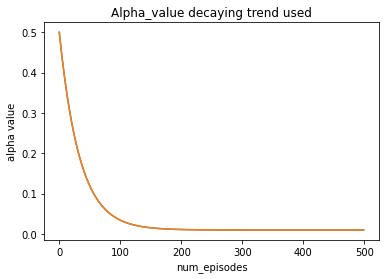

In [34]:
env_name = "environments:random_walk_env-v0"

env = gym.make(env_name)

num_episodes = 500
max_steps = 30

# EVMC
v_comp_right_EV, running_values_right_EV, target_values_EV = MonteCarloPrediction(env, right_policy, 
                                                                                  max_steps, num_episodes, False, gamma)
#v_comp_left = MonteCarloPrediction(env, left_policy, 20, 500, False, gamma)

print("estimated solution(FV):\n[v(0), v(1), v(2), v(3), v(4), v(5), v(6)] :")
print(v_comp_right_EV)



# FVMC
v_comp_right_FV, running_values_right_FV, target_values_FV = MonteCarloPrediction(env, right_policy, max_steps, num_episodes, True, gamma)
#v_comp_left = MonteCarloPrediction(env, left_policy, 20, 500, True, gamma)
print("estimated solution(EV):\n[v(0), v(1), v(2), v(3), v(4), v(5), v(6)] :")
print(v_comp_right_FV)


print("optimal solution:\n[v(0), v(1), v(2), v(3), v(4), v(5), v(6)] :")
print(v_sol)

# Compute average to reduce variance
These values are little off to the real values, lets compute an average of some number of computations so that the noise is effectively averaged out.

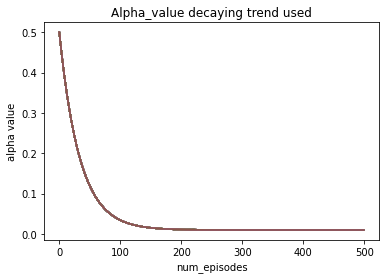

In [41]:
num = 50

for i in range(2, num):
    mc_value_FV, running_FV, target_FV = MonteCarloPrediction(env, right_policy, max_steps, num_episodes, False,gamma)
    mc_value_EV, running_EV, target_EV = MonteCarloPrediction(env, right_policy, max_steps, num_episodes, True, gamma)
    
    v_comp_right_FV += (mc_value_FV - v_comp_right_FV)/i
    min_len = min(running_FV.shape[0], running_values_right_FV.shape[0])
    running_values_right_FV[:min_len, :] += (running_FV[:min_len, :] - running_values_right_FV[:min_len, :])/i
    #min_len = min(target_FV.shape[0], target_values_FV.shape[0])
    #print(min_len)
    #target_values_FV[:min_len] += (target_FV[:min_len] - target_values_FV[:min_len])/i
    
    v_comp_right_EV += (mc_value_EV - v_comp_right_EV)/i
    min_len = min(running_EV.shape[0], running_values_right_EV.shape[0])
    #print(min_len)
    running_values_right_EV[:min_len, :] += (running_EV[:min_len, :] - running_values_right_EV[:min_len, :])/i
    #min_len = min(target_EV.shape[0], target_values_EV.shape[0])
    #print(min_len)
    #target_values_EV[:min_len] += (target_EV[:min_len] - target_values_EV[:min_len])/i
    

# MC-FVMC estimate of each non-terminal state of RWE (2.5, 2.8)

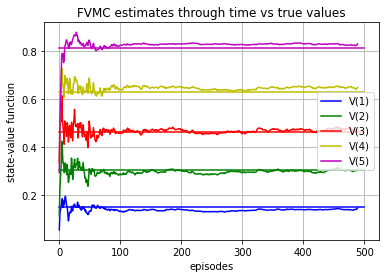

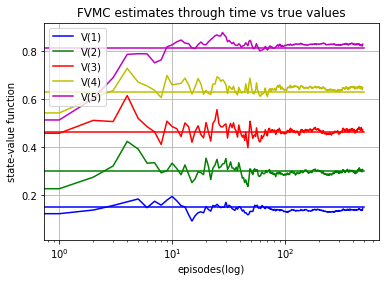

In [42]:
plt.figure(1)
plt.title("FVMC estimates through time vs true values")
plt.ylabel("state-value function")
plt.xlabel("episodes")

plt.plot([v_sol[1]] * num_episodes, color='b')
plt.plot([v_sol[2]] * num_episodes, color='g')
plt.plot([v_sol[3]] * num_episodes, color='r')
plt.plot([v_sol[4]] * num_episodes, color='y')
plt.plot([v_sol[5]] * num_episodes, color='m')

plt.plot(running_values_right_FV[:, 1:2], color ='b', label='V(1)')
plt.plot(running_values_right_FV[:, 2:3], color='g', label='V(2)')
plt.plot(running_values_right_FV[:, 3:4], color='r', label='V(3)')
plt.plot(running_values_right_FV[:, 4:5], color='y', label='V(4)')
plt.plot(running_values_right_FV[:, 5:6], color='m', label='V(5)')

plt.grid()
plt.legend()


plt.figure(2)
plt.title("FVMC estimates through time vs true values")
plt.ylabel("state-value function")
plt.xlabel("episodes(log)")

plt.plot([v_sol[1]] * num_episodes, color='b')
plt.plot([v_sol[2]] * num_episodes, color='g')
plt.plot([v_sol[3]] * num_episodes, color='r')
plt.plot([v_sol[4]] * num_episodes, color='y')
plt.plot([v_sol[5]] * num_episodes, color='m')

plt.plot(running_values_right_FV[:, 1:2], color='b', label='V(1)')
plt.plot( running_values_right_FV[:, 2:3], color='g', label='V(2)')
plt.plot( running_values_right_FV[:, 3:4],  color='r', label='V(3)')
plt.plot(running_values_right_FV[:, 4:5],  color='y', label='V(4)')
plt.plot( running_values_right_FV[:, 5:6],  color='m', label='V(5)')
plt.xscale('log')

plt.legend()
plt.grid()

# MC-EVMC estimate of each non-terminal state of RWE (2.6, 2.9)

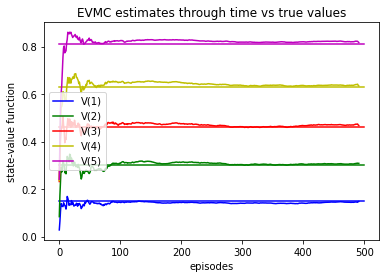

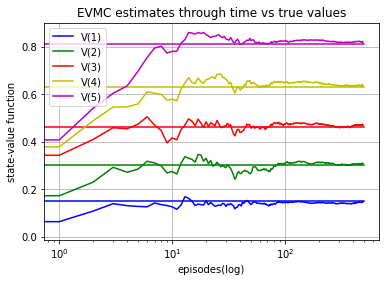

In [43]:
plt.figure(3)
plt.title("EVMC estimates through time vs true values")
plt.ylabel("state-value function")
plt.xlabel("episodes")

plt.plot([v_sol[1]] * num_episodes, color='b')
plt.plot([v_sol[2]] * num_episodes, color='g')
plt.plot([v_sol[3]] * num_episodes, color='r')
plt.plot([v_sol[4]] * num_episodes, color='y')
plt.plot([v_sol[5]] * num_episodes, color='m')

plt.plot(running_values_right_EV[:, 1:2], color='b', label='V(1)')
plt.plot(running_values_right_EV[:, 2:3], color='g', label='V(2)')
plt.plot(running_values_right_EV[:, 3:4], color='r', label='V(3)')
plt.plot(running_values_right_EV[:, 4:5], color='y', label='V(4)')
plt.plot(running_values_right_EV[:, 5:6], color='m', label='V(5)')
plt.legend()

plt.figure(4)
plt.title("EVMC estimates through time vs true values")
plt.ylabel("state-value function")
plt.xlabel("episodes(log)")

plt.plot([v_sol[1]] * num_episodes, color='b')
plt.plot([v_sol[2]] * num_episodes, color='g')
plt.plot([v_sol[3]] * num_episodes, color='r')
plt.plot([v_sol[4]] * num_episodes, color='y')
plt.plot([v_sol[5]] * num_episodes, color='m')

plt.plot(running_values_right_EV[:, 1:2],  color='b', label='V(1)')
plt.plot( running_values_right_EV[:, 2:3],  color='g', label='V(2)')
plt.plot(running_values_right_EV[:, 3:4], color='r',label='V(3)')
plt.plot( running_values_right_EV[:, 4:5],  color='y',label='V(4)')
plt.plot(running_values_right_EV[:, 5:6],  color='m',label='V(5)')

plt.xscale('log')
plt.grid()
plt.legend()

# Target Value Graphs for FVMC, EVMC (2.12, 2.13)

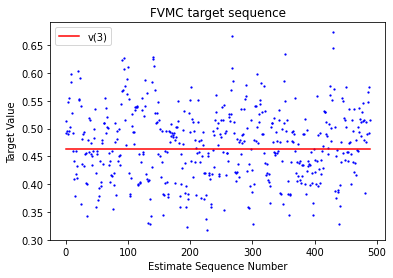

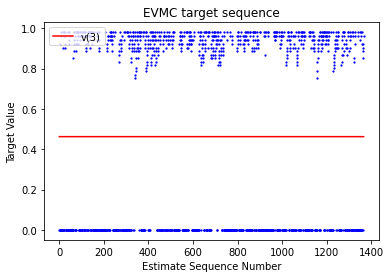

In [45]:
plt.figure(5)
plt.title("FVMC target sequence")
plt.ylabel("Target Value")
plt.xlabel("Estimate Sequence Number")
plt.plot(np.array(range(len(target_values_FV))), [v_sol[3]]*len(target_values_FV), color='r', label = "v(3)")
plt.scatter(np.array(range(len(target_values_FV))), target_values_FV, color='b', s= 1.5)
plt.legend()

plt.figure(6)
plt.title("EVMC target sequence")
plt.ylabel("Target Value")
plt.xlabel("Estimate Sequence Number")
plt.plot(np.array(range(len(target_values_EV))), [v_sol[3]]*len(target_values_EV), color='r', label = "v(3)")
plt.scatter(np.array(range(len(target_values_EV))), target_values_EV, color='b', s= 1.5)
plt.legend()

